<div style="width: 100%; clear: both; font-family: Verdana;">
<div style="float: left; width: 50%;font-family: Verdana;">
<img src="https://github.com/Eligoze/att-rci-internal/blob/qa/RCI_DataAnalysis/eda/doc/att-logo1.png" align="left">
</div>
<div style="float: right; width: 200%;">
<p style="margin: 0; padding-top: 20px; text-align:right;color:rgb(193, 38, 184)"><strong>Axity - AT&T.
    Ciclo de vida de elementos de inventario</strong></p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

<div style="width: 100%; clear: both; font-family: Verdana;">
<h1 align="center">Exploratory Data Analysis</h1>
</div>

### Descripción
Analizaremos los datos de las fuentes de inventarios de AT&T con un tratamiento estadístico descriptivo para hacer el tracking del ciclo de vida de los elementos de red. Se creará un EDA enfocado a la salida de almacén. Serán documentados los catálogos propuestos junto a su respectivo tratamiento de datos. La fuente que corresponde a este análisis es:

* **Segregación Almacén (Almacén inventario)**  

Primero cargamos las librerías necesarias.

## Se tomará para el análisis la partición correspondiente a Noviembre 28 

#### Conectando al Datalake

In [1]:
import os
os.environ['JAVA_HOME'] = '/usr/java/jdk1.8.0_162'
os.environ['SPARK_HOME'] = '/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark'
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import HiveContext

In [2]:
conf = SparkConf().setAppName('Segregacion')  \
    .setMaster('yarn').set("spark.yarn.queue","root.eda")
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext
sqlContext = HiveContext(sc)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import re

from pyspark.sql.functions import udf ,col
from pyspark.sql.types import IntegerType,StringType

%matplotlib inline

from bokeh.io import show, output_notebook, output_file 
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category20_11, Category20c_20, Category10_5,Category10_6, Category20_20, Plasma256
output_notebook()

Loading BokehJS ...

### Recolección de los datos: 

#### Creamos una función para tratamiento de datos en spark:

In [4]:
def validate_rule(string):
    search_list=[u" ",u'!',u'%',u'$',u'¡',u'¿',u'~',u'#',u'Ñ',u"Ã",u"Åƒ",u"Ã‹",u"Ã³",u'Ë',u'*',u"ILEGIBLE", u"VICIBLE",u"VISIBLE",u"INCOMPLETO"]    
    str_temp = string
    if str_temp.upper() == u"BORRADO":
      return 1
    elif len(str_temp) < 6:
      return 1
    elif any(ext in str_temp.upper()for ext in search_list):
      return 1
    else:
      return 0

Esta fuente en particular contiene la historia de los elementos en el almacén, consideramos las fechas de cada partición, es decir, fechas de cada archivo ingestado. Para conocer las particiones de la fuente es necesario realizar un query en el cluster **SHOW PARTITIONS tx_almacen_inventory** y escogemos las particiones del mes que se quiere analizar.

_10=spark.sql("SELECT id, qr as qr_alm, org,sub_inv,almacen, articulo,descripcion,lpn_nuevo, ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,datasetname,filedate,year,month,day FROM tx_almacen_inventory WHERE year=2019 and month=09 and day=10")
df_10=_10.toPandas()

_11=spark.sql("SELECT id, qr as qr_alm, org,sub_inv,almacen, articulo,descripcion,lpn_nuevo, ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,datasetname,filedate,year,month,day FROM tx_almacen_inventory WHERE year=2019 and month=09 and day=11")
df_11=_11.toPandas()

_12=spark.sql("SELECT id, qr as qr_alm, org,sub_inv,almacen, articulo,descripcion,lpn_nuevo, ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,datasetname,filedate,year,month,day FROM tx_almacen_inventory WHERE year=2019 and month=09 and day=12")
df_12=_12.toPandas()

_13=spark.sql("SELECT id, qr as qr_alm, org,sub_inv,almacen, articulo,descripcion,lpn_nuevo, ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,datasetname,filedate,year,month,day FROM tx_almacen_inventory WHERE year=2019 and month=09 and day=13")
df_13=_13.toPandas()

_17=spark.sql("SELECT id, qr as qr_alm, org,sub_inv,almacen, articulo,descripcion,lpn_nuevo, ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,datasetname,filedate,year,month,day FROM tx_almacen_inventory WHERE year=2019 and month=09 and day=17")
df_17=_17.toPandas()

_18=spark.sql("SELECT id, qr as qr_alm, org,sub_inv,almacen, articulo,descripcion,lpn_nuevo, ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,datasetname,filedate,year,month,day FROM tx_almacen_inventory WHERE year=2019 and month=09 and day=18")
df_18=_18.toPandas()

_19=spark.sql("SELECT id, qr as qr_alm, org,sub_inv,almacen, articulo,descripcion,lpn_nuevo, ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,datasetname,filedate,year,month,day FROM tx_almacen_inventory WHERE year=2019 and month=09 and day=19")
df_19=_19.toPandas()

_24=spark.sql("SELECT id, qr as qr_alm, org,sub_inv,almacen, articulo,descripcion,lpn_nuevo, ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,datasetname,filedate,year,month,day FROM tx_almacen_inventory WHERE year=2019 and month=09 and day=24")
df_24=_24.toPandas()

_26=spark.sql("SELECT id, qr as qr_alm, org,sub_inv,almacen, articulo,descripcion,lpn_nuevo, ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,datasetname,filedate,year,month,day FROM tx_almacen_inventory WHERE year=2019 and month=09 and day=26")
df_26=_26.toPandas()

_03=spark.sql("SELECT id, qr as qr_alm, org,sub_inv,almacen, articulo,descripcion,lpn_nuevo, ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,datasetname,filedate,year,month,day FROM tx_almacen_inventory WHERE year=2019 and month=09 and day=03")
df_03=_03.toPandas()

_30=spark.sql("SELECT id, qr as qr_alm, org,sub_inv,almacen, articulo,descripcion,lpn_nuevo, ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,estatus_cip,datasetname,filedate,year,month,day FROM tx_almacen_inventory WHERE year=2019 and month=09 and day=30")

validate_rule_udf = udf(validate_rule, IntegerType())
df_serie = _30.withColumn("serie_cleaned",validate_rule_udf(col("serie")))

df_30=df_serie.toPandas()

_04=spark.sql("SELECT id, qr as qr_alm, org,sub_inv,almacen, articulo,descripcion,lpn_nuevo, ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,datasetname,filedate,year,month,day FROM tx_almacen_inventory WHERE year=2019 and month=09 and day=04")
df_04=_04.toPandas()

_05=spark.sql("SELECT id, qr as qr_alm, org,sub_inv,almacen, articulo,descripcion,lpn_nuevo, ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,datasetname,filedate,year,month,day FROM tx_almacen_inventory WHERE year=2019 and month=09 and day=05")
df_05=_05.toPandas()

_06=spark.sql("SELECT id, qr as qr_alm, org,sub_inv,almacen, articulo,descripcion,lpn_nuevo, ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,datasetname,filedate,year,month,day FROM tx_almacen_inventory WHERE year=2019 and month=09 and day=06")
df_06=_06.toPandas()

_09=spark.sql("SELECT id, qr as qr_alm, org,sub_inv,almacen, articulo,descripcion,lpn_nuevo, ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,datasetname,filedate,year,month,day FROM tx_almacen_inventory WHERE year=2019 and month=09 and day=09")
df_09=_09.toPandas()

In [5]:
_28Nov=spark.sql("SELECT id, qr as qr_alm, org,sub_inv,almacen, articulo,descripcion,lpn_nuevo, ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,usd,tipo_de_ubicacion_resum_1,datasetname,filedate,year,month,day FROM tx_almacen_inventory WHERE year=2019 and month=11 and day=28").cache() 

validate_rule_udf = udf(validate_rule, IntegerType())
df_serie = _28Nov.withColumn("serie_cleaned",validate_rule_udf(col("serie")))

df_28Nov=df_serie.toPandas()

*Hemos recolectado los campos a analizar de la fuente: inventario almacén.*

frames=[df_03,df_04,df_05,df_06,
        df_09,df_10,df_11,df_12,
        df_13,df_17,df_18,df_19,
        df_24,df_26,df_30]
df=pd.concat(frames,ignore_index=True)

In [6]:
df=df_28Nov

## Segregación Almacén
Una visualización de la fuente de segregación.

In [7]:
df.head(15)

,id,qr_alm,org,sub_inv,almacen,articulo,descripcion,lpn_nuevo,ubicacion_nueva,estado_fisico_usadonuevo,...,activo,mxn,usd,tipo_de_ubicacion_resum_1,datasetname,filedate,year,month,day,serie_cleaned
0,22,2PX1S19-001051,2PX,NUEVOS,DHL Tepotzotlan,W.9044002,MICROWAVE ANTENNA 1.2M WITH SUPPORT HARDWARE...,ANC2018073000010,FR002A,NUEVO,...,2840187.0,,667.7504461461715,Warehouse,sa_almacen_inventory,20191128,2019,11,28,0
1,22,2PX1S19-001051,2PX,NUEVOS,DHL Tepotzotlan,W.9044002,MICROWAVE ANTENNA 1.2M WITH SUPPORT HARDWARE...,ANC2018073000010,FR002A,NUEVO,...,2840187.0,,667.7504461461715,Warehouse,sa_almacen_inventory,20191128,2019,11,28,0
2,23,2PX1S19-001051,2PX,NUEVOS,DHL Tepotzotlan,W.9044002,MICROWAVE ANTENNA 1.2M WITH SUPPORT HARDWARE...,ANC2018073000010,FR002A,NUEVO,...,2840183.0,,667.7504461461715,Warehouse,sa_almacen_inventory,20191128,2019,11,28,0
3,23,2PX1S19-001051,2PX,NUEVOS,DHL Tepotzotlan,W.9044002,MICROWAVE ANTENNA 1.2M WITH SUPPORT HARDWARE...,ANC2018073000010,FR002A,NUEVO,...,2840183.0,,667.7504461461715,Warehouse,sa_almacen_inventory,20191128,2019,11,28,0
4,29,2PX1S19-001051,2PX,NUEVOS,DHL Tepotzotlan,W.9044002,MICROWAVE ANTENNA 1.2M WITH SUPPORT HARDWARE...,ANC2018073000010,FR002A,NUEVO,...,2840196.0,,667.7504461461715,Warehouse,sa_almacen_inventory,20191128,2019,11,28,0
5,29,2PX1S19-001051,2PX,NUEVOS,DHL Tepotzotlan,W.9044002,MICROWAVE ANTENNA 1.2M WITH SUPPORT HARDWARE...,ANC2018073000010,FR002A,NUEVO,...,2840196.0,,667.7504461461715,Warehouse,sa_almacen_inventory,20191128,2019,11,28,0
6,30,2PX1S19-001051,2PX,NUEVOS,DHL Tepotzotlan,W.9044002,MICROWAVE ANTENNA 1.2M WITH SUPPORT HARDWARE...,ANC2018073000010,FR002A,NUEVO,...,2840191.0,,667.7504461461715,Warehouse,sa_almacen_inventory,20191128,2019,11,28,0
7,30,2PX1S19-001051,2PX,NUEVOS,DHL Tepotzotlan,W.9044002,MICROWAVE ANTENNA 1.2M WITH SUPPORT HARDWARE...,ANC2018073000010,FR002A,NUEVO,...,2840191.0,,667.7504461461715,Warehouse,sa_almacen_inventory,20191128,2019,11,28,0
8,33,2PX1S19-001051,2PX,NUEVOS,DHL Tepotzotlan,W.9044002,MICROWAVE ANTENNA 1.2M WITH SUPPORT HARDWARE...,ANC2018073000010,FR002A,NUEVO,...,2840194.0,,667.7504461461715,Warehouse,sa_almacen_inventory,20191128,2019,11,28,0
9,33,2PX1S19-001051,2PX,NUEVOS,DHL Tepotzotlan,W.9044002,MICROWAVE ANTENNA 1.2M WITH SUPPORT HARDWARE...,ANC2018073000010,FR002A,NUEVO,...,2840194.0,,667.7504461461715,Warehouse,sa_almacen_inventory,20191128,2019,11,28,0


In [8]:
df.columns

Index([u'id', u'qr_alm', u'org', u'sub_inv', u'almacen', u'articulo',
       u'descripcion', u'lpn_nuevo', u'ubicacion_nueva',
       u'estado_fisico_usadonuevo', u'tipo_de_articulo', u'serie', u'etiqueta',
       u'activo', u'mxn', u'usd', u'tipo_de_ubicacion_resum_1', u'datasetname',
       u'filedate', u'year', u'month', u'day', u'serie_cleaned'],
      dtype='object')

### Diccionario de datos

A continuación se enlistan los campos de la fuente con una breve descripción de negocio.  **Carina**
    
* **id**: Código interno que identifica al elemento en el almacén.
* **qr**: Código QR interno que identifica al elemento en el almacén por organización.
* **org**: Código que identifica sitios en un almacén.
* **subinv**: Señala estado del articulo (Nuevo, usado, obsoleto, dañado, ...).
* **almacen**:Nombre del almacén en el que se encuentra el elemento.
* **articulo**: Identificador único de Oracle.
* **descripcion**: Descripción general del elemento.
* **upd**: Unidad de medida.
* **lpn_nuevo**: Identificador QR de un elemento cuando ha cambiado de almacén.
* **ubicacion_nueva**: Ubicación dentro del almacén a donde se ha movido el elemento.
* **estado_fisico**: Estatus del elemento (Nuevo, usado).
* **cantidad**: Número de elementos.
* **tipo de control**: Identificador de como se encontró el elemento.
* **pasillo**: Pasillo donde se encuentra el elemento.
* **nivel**: Nivel donde se encuentra el elemento.
* **parnon**: Parnon donde se encuentra el elemento.
* **tipo_articulo**: Tipo de Artículo.
* **serie**: Identificador único que tiene el proveedor.
* **etiqueta**: Id único del elemento de red que da AT&T (Activo).


### 2. Descripción de las fuentes.
En este apartado se hará una descripción a detalle de las fuentes para una mejor comprensión de los datos. Por cada fuente se mostrarán los tipos de datos, tamaño de la fuente, es decir, su dimensionalidad y una estadística descriptiva, en ese orden.

In [9]:
camposSegg=df.columns
print('Columnas de la fuente segregacion son: ',list(camposSegg))
pd.DataFrame(df.dtypes,columns=['Tipo de objeto Segregación'])

('Columnas de la fuente segregacion son: ', ['id', 'qr_alm', 'org', 'sub_inv', 'almacen', 'articulo', 'descripcion', 'lpn_nuevo', 'ubicacion_nueva', 'estado_fisico_usadonuevo', 'tipo_de_articulo', 'serie', 'etiqueta', 'activo', 'mxn', 'usd', 'tipo_de_ubicacion_resum_1', 'datasetname', 'filedate', 'year', 'month', 'day', 'serie_cleaned'])


,Tipo de objeto Segregación
id,object
qr_alm,object
org,object
sub_inv,object
almacen,object
articulo,object
descripcion,object
lpn_nuevo,object
ubicacion_nueva,object
estado_fisico_usadonuevo,object


In [10]:
print('renglones = ',df.shape[0],' columnas = ',df.shape[1])

('renglones = ', 356922, ' columnas = ', 23)


In [11]:
NOrelevantes=['filedate', 'filename', 'hash_id', 'sourceid',
              'registry_state', 'datasetname', 'timestamp',
              'transaction_status', 'year', 'month', 'day']

relevantes=[v for v in df.columns if v not in NOrelevantes]

df[relevantes].describe(include='all')

,id,qr_alm,org,sub_inv,almacen,articulo,descripcion,lpn_nuevo,ubicacion_nueva,estado_fisico_usadonuevo,tipo_de_articulo,serie,etiqueta,activo,mxn,usd,tipo_de_ubicacion_resum_1,serie_cleaned
count,356922,356922,356922,356922,356922,356922,356922,356922,356922,356922,356922,356922,356922,356922,356922,356922,356922,356922.000000
unique,333471,15257,48,19,46,10586,10934,10873,7949,5,7,298327,182737,68820,1,2533,4,NaN
top,111768,0.0,2PX,USADODISP,DHL Tepotzotlan,W.1013182,ANTENA TIPO: DIRECTED POLE PANEL POLARIZACION:...,0.0,0.0,NUEVO,W,,,,,,,NaN
freq,4,215668,156022,182684,156022,8362,8105,214612,214612,327096,196192,35094,150084,266108,356922,266108,260600,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.127966
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.334053
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


#### De esta tabla describe, podemos observar que hay:
* Podría crearse un catálogo de almacenes, tipos de artículo y sub_inv
* En su mayoría, contamos con variables categóricas, razón por la cuál las secciones estadísticas no arrojan información. 


Se proponen los siguientes catálogos derivados de la fuente de Almacén Inventario:

* **sub_inv**: Señala estado del articulo (Nuevo, usado, obsoleto, dañado, ...).
* **almacen**: Nombre del almacén en el que se encuentra el elemento.
* **tipo_articulo**: Tipo de Artículo.

Estos catálogos nos ayudarán a mapear todas las diferentes variantes que existen para cada elemento. 

Se utilizó el catálogo de Almacenes **Info_almacenes**.

### 3. Exploración de los datos.
De acuerdo al análisis anterior, procedemos a hacer una exploración de los datos con gráficas, de manera particular nos enfocaremos en los catálogos. 

#### Para empezar, haremos una limpieza por columna:

In [12]:
df.qr_alm.replace('0',np.NaN,inplace=True)
df.lpn_nuevo.replace('0',np.NaN,inplace=True)
df.ubicacion_nueva.replace('0',np.NaN,inplace=True)
df.estado_fisico_usadonuevo.replace('0',np.NaN,inplace=True)
df.estado_fisico_usadonuevo.replace('-',np.NaN,inplace=True)
df.etiqueta.replace('',np.NaN,inplace=True)
df.serie.replace('',np.NaN,inplace=True)
df.activo.replace('',np.NaN,inplace=True)
df.mxn.replace('',np.NaN,inplace=True)

In [13]:
df.serie[(df.serie=='INCOMPLETO') | (df.serie=='ILEGIBLE') | 
     (df.serie=='BORRADO') | (df.serie=='VICIBLE') | 
     (df.serie=='VISIBLE')]=np.NaN
      
df.etiqueta[(df.etiqueta=='NOTIENE') | (df.etiqueta=='REVISAR') |
     (df.etiqueta=='VISIBLE') | (df.etiqueta=='ERROR') |
     (df.etiqueta=='VIDIBLE') | (df.etiqueta=='SINACTIVO') |
     (df.etiqueta=='ILEGIBLE') | (df.etiqueta=='IP3CAB6CAA') |
     (df.etiqueta=='3G113642') | (df.etiqueta=='3G083109') | 
     (df.etiqueta=='VISIVLE')]=np.NaN


especiales=['!','¡',u'¿','~','#','Ñ',"Ã“","Åƒ","Ã‹","Ã³",'Ë']
df.replace(especiales,np.NaN,regex=True,inplace=True)

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


#### Primer catálogo: *sub_inv*.

Empezaremos con el catálogo de sub_inv. Siendo un catálogo con entradas manuales, aplicaremos una limpieza a los datos para poder trabajarlos.

In [14]:
aux=["Ã“","Åƒ","Ã‹","Ã³"]
df.sub_inv=df.sub_inv.str.upper()
df.sub_inv.replace(u'Á',u'A', regex=True, inplace=True)
df.sub_inv.replace(u'É',u'E', regex=True, inplace=True)
df.sub_inv.replace(u'Í',u'I', regex=True, inplace=True)
df.sub_inv.replace(u'Ó',u'O', regex=True, inplace=True)
df.sub_inv.replace(u'Ú',u'U', regex=True, inplace=True)
df.sub_inv.replace(u'Ń',u'U', regex=True, inplace=True)
df.sub_inv.replace(u'Đ',u'N', regex=True, inplace=True)
df.sub_inv.replace(u'Ñ',u'N', regex=True, inplace=True)
df.sub_inv.replace(u'Ë',u'E', regex=True, inplace=True)
df.sub_inv.replace(u'USADIS',u'USADO', regex=True, inplace=True)
df.sub_inv.replace(u'USADODISP',u'USADO', regex=True, inplace=True)
df.sub_inv.replace(u'UDISP',u'USADO', regex=True, inplace=True)
df.sub_inv.replace(u'USADOS',u'USADO', regex=True, inplace=True)
df.sub_inv.replace(u'OBSOLETO',u'OBS', regex=True, inplace=True)
df.sub_inv.replace(u'NUEVOS',u'NUEVO', regex=True, inplace=True)
df.sub_inv.replace(u'ACLARACIEN',u'ACLARACION', regex=True, inplace=True)
df.sub_inv.replace(u'DANADO',u'DAN', regex=True, inplace=True)
df.sub_inv.replace(u'REFA-DAU',u'REFA-DAN', regex=True, inplace=True)
df.sub_inv.replace(u'RF',u'REFA', regex=True, inplace=True)
df.sub_inv.replace(aux,'', regex=True, inplace=True)
df.sub_inv=df.sub_inv.str.strip()

catsub_inv=pd.DataFrame(df.sub_inv.value_counts())
index=list(range(0,catsub_inv.shape[0]))           
subinv=pd.DataFrame(catsub_inv.index,index=index)
subinv.columns=['Sub_inventario']
catsub_inv.index=index
catsub_inv.columns=['Frecuencia']
catsub_inv=pd.concat([subinv,catsub_inv],axis=1)
catsub_inv

,Sub_inventario,Frecuencia
0,USADO,182899
1,NUEVO,138258
2,REFA-USADO,11272
3,REFA-NUEVO,8980
4,OBS,8320
5,IBS-NUEVO,5495
6,REFA-DAÐ,578
7,REFA-OBS,531
8,MOBILIARIO,328
9,DAN,90


Después de limpiar el catálogo, ahora podemos hacer la visualización más adecuada.
Empezaremos usando un Histograma.

Text(0.5,1,'Distribucion de los estados del Inventario de Almacen')

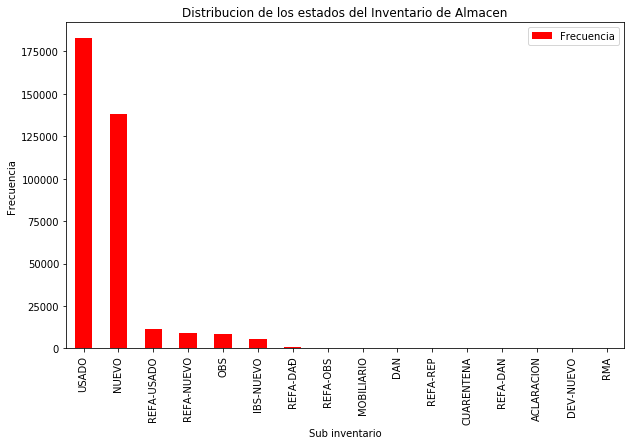

In [15]:
catsub_inv.plot(x='Sub_inventario',
                y='Frecuencia',
                kind='bar',
                figsize=(10,6),
                rot=90,colormap='rainbow_r')
plt.xlabel('Sub inventario')
plt.ylabel('Frecuencia')
plt.title('Distribucion de los estados del Inventario de Almacen')

Parece que hemos logrado un catálogo bien definido. Podrá revisarse en la sección de catálogos.

#### Segundo catálogo: *Almacén*
Seguimos el mismo procedimiento, limpieza, normalización y visualización.

In [16]:
alm_catalogo=pd.read_csv('/home/cz014h/Info_Almacenes_clean.csv')
alm_catalogo.columns=['org','almacen','latitud','longitud']

df.merge(alm_catalogo,on='org', how='left')
df.head()

,id,qr_alm,org,sub_inv,almacen,articulo,descripcion,lpn_nuevo,ubicacion_nueva,estado_fisico_usadonuevo,...,activo,mxn,usd,tipo_de_ubicacion_resum_1,datasetname,filedate,year,month,day,serie_cleaned
0,22,2PX1S19-001051,2PX,NUEVO,DHL Tepotzotlan,W.9044002,MICROWAVE ANTENNA 1.2M WITH SUPPORT HARDWARE...,ANC2018073000010,FR002A,NUEVO,...,2840187.0,NaN,667.7504461461715,Warehouse,sa_almacen_inventory,20191128,2019,11,28,0
1,22,2PX1S19-001051,2PX,NUEVO,DHL Tepotzotlan,W.9044002,MICROWAVE ANTENNA 1.2M WITH SUPPORT HARDWARE...,ANC2018073000010,FR002A,NUEVO,...,2840187.0,NaN,667.7504461461715,Warehouse,sa_almacen_inventory,20191128,2019,11,28,0
2,23,2PX1S19-001051,2PX,NUEVO,DHL Tepotzotlan,W.9044002,MICROWAVE ANTENNA 1.2M WITH SUPPORT HARDWARE...,ANC2018073000010,FR002A,NUEVO,...,2840183.0,NaN,667.7504461461715,Warehouse,sa_almacen_inventory,20191128,2019,11,28,0
3,23,2PX1S19-001051,2PX,NUEVO,DHL Tepotzotlan,W.9044002,MICROWAVE ANTENNA 1.2M WITH SUPPORT HARDWARE...,ANC2018073000010,FR002A,NUEVO,...,2840183.0,NaN,667.7504461461715,Warehouse,sa_almacen_inventory,20191128,2019,11,28,0
4,29,2PX1S19-001051,2PX,NUEVO,DHL Tepotzotlan,W.9044002,MICROWAVE ANTENNA 1.2M WITH SUPPORT HARDWARE...,ANC2018073000010,FR002A,NUEVO,...,2840196.0,NaN,667.7504461461715,Warehouse,sa_almacen_inventory,20191128,2019,11,28,0


#### Veamos en un mapa la distribución de los almacenes:

In [17]:
mapa_alm=alm_catalogo.loc[:,['almacen','latitud','longitud']].dropna()
mapa_alm.drop_duplicates(inplace=True)

import folium
from folium import plugins

Latitud=21.607871
Longitud=-101.201933
mapa=folium.Map(location=[Latitud,Longitud],zoom_start=4.8)

storages = folium.map.FeatureGroup()

for lat, lng, in zip(mapa_alm.latitud, mapa_alm.longitud):
    storages.add_child(
        folium.features.Marker(
            [lat, lng]
        )
    )
    
latitudes = list(mapa_alm.latitud)
longitudes = list(mapa_alm.longitud)
labels = list(mapa_alm.almacen)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(storages) 
mapa.save('Mapa de almacenes ATT.html')
mapa.add_child(storages)

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/folium/__init__.py:59: UserWarning: This version of folium is the last to support Python 2. Transition to Python 3 to be able to receive updates and fixes. Check out https://python3statement.org/ for more info.
  UserWarning


In [18]:
aux=df.loc[:,['org','almacen','tipo_de_articulo','serie','activo','mxn','etiqueta']]
#aux.dropna(thresh=5,inplace=True)
aux.head()

,org,almacen,tipo_de_articulo,serie,activo,mxn,etiqueta
0,2PX,DHL Tepotzotlan,W,21524311663AG7004232,2840187.0,NaN,00895089
1,2PX,DHL Tepotzotlan,W,21524311663AG7004232,2840187.0,NaN,00895089
2,2PX,DHL Tepotzotlan,W,21524311663AG7004237,2840183.0,NaN,00895091
3,2PX,DHL Tepotzotlan,W,21524311663AG7004237,2840183.0,NaN,00895091
4,2PX,DHL Tepotzotlan,W,21524311663AG7004263,2840196.0,NaN,00895099


#### Normalización:

In [19]:
counts=(aux.almacen.value_counts()/aux.almacen.value_counts().sum())*100

Ind=list(range(0,len(counts)))
Alm_counts=pd.DataFrame(counts)
Alm_counts.columns=['Porcentaje']
Almacenes=pd.DataFrame(Alm_counts.index)
Almacenes.columns=['almacen']
Alm_counts.index=Ind
Alm_counts= pd.concat([Almacenes,Alm_counts],axis=1)

for v in range(0,len(counts)):
    if Alm_counts.Porcentaje[v] < 3:
        Alm_counts.almacen[v]='Otros'

Alm_counts.Porcentaje.loc[Alm_counts['almacen'] == 'Otros'] = Alm_counts[Alm_counts.almacen=='Otros'].Porcentaje.sum()
Alm_counts=Alm_counts.head(5)
Alm_counts

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,almacen,Porcentaje
0,DHL Tepotzotlan,43.713192
1,Sta Cecilia AT&T,36.641619
2,PROVA SMO,7.832524
3,Glaco AT&T,3.948202
4,Otros,7.864463


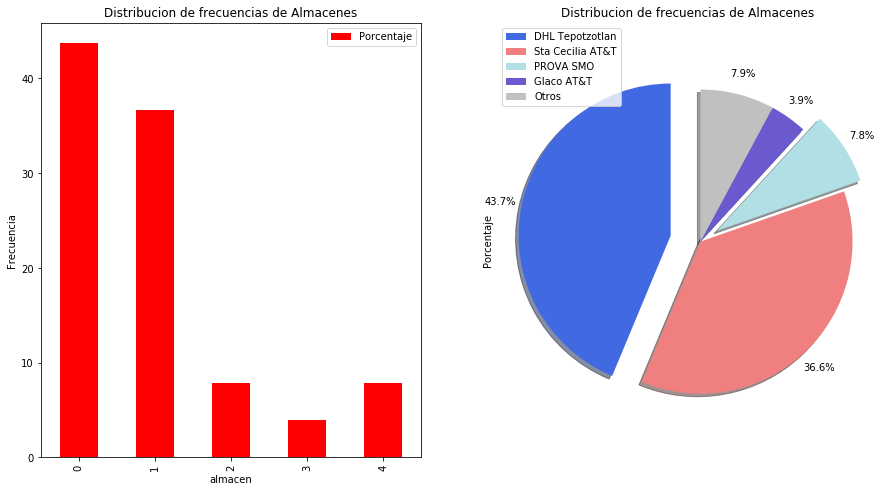

In [20]:
#Visualización:
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

#Subplot1: Bar chart
Alm_counts.plot(kind='bar',figsize=(10,6),colormap='rainbow_r',ax=ax0)
ax0.set_xlabel('almacen')
ax0.set_ylabel('Frecuencia')
ax0.set_title('Distribucion de frecuencias de Almacenes')

#Subplot2: Bar chart
explode_list=[.2,0,.13,0,0]
color_list=['royalblue','lightcoral','powderblue','slateblue','silver']
Alm_counts['Porcentaje'].plot(kind='pie',         
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                               ax=ax1,
                    explode=explode_list)
ax1.set_title('Distribucion de frecuencias de Almacenes')
ax1.axis('equal')
ax1.legend(labels=Alm_counts.almacen,loc='upper left')

plt.show()

Podemos observar que es en los almacenes: "**DHL Tepotzotlan, STA Cecilia y** y los correspondientes a **PROVA SMO**" donde se distribuyen la mayoría de elementos.  
Esto podría ser un indicador interesante en un futuro. Se encontrará el catálogo en la sección de catálogos.

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> Tercer catálogo: <strong>Tipo de artículo</strong>.
        <br>Procederemos a usar limpieza  en caso necesario y visualización.
        </p>
</div>

In [21]:
df.tipo_de_articulo=df.tipo_de_articulo.str.upper()
aux.tipo_de_articulo=aux.tipo_de_articulo.str.upper()
TipoArt=pd.DataFrame(aux.tipo_de_articulo.unique())
TipoArt.columns=['Tipo_Artículo']
TipoArt

,Tipo_Artículo
0,W
1,V
2,T
3,C
4,NP
5,N


In [22]:
ArtCounts=pd.Series((aux.tipo_de_articulo.value_counts()/aux.tipo_de_articulo.value_counts().sum())*100)
TipoArt['Porcentaje']=ArtCounts.values

columnas=list(TipoArt['Tipo_Artículo'])
Freq=list(TipoArt.Porcentaje)
source=ColumnDataSource(dict(columnas=columnas, Freq=Freq, color=Category10_6))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,80),
         title='Distribución de los tipos de Artículo')
p.vbar(x='columnas',top='Freq',width=.5, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
TipoArt

,Tipo_Artículo,Porcentaje
0,W,54.967752
1,V,37.021814
2,T,6.754697
3,C,1.109486
4,NP,0.145970
5,N,0.000280


<div style="width: 100%; clear: both; font-family: Verdana;">
<h2>4. Calidad de los datos</h2>
    <p> Se documentará la calidad de los datos y analizará las variables que necesitan tratamiento con la ayuda de visualizaciones y tablas.
    </p>
</div>

#### Missings Values
Los missings values son los valores faltantes en el conjunto de datos que se refieren a aquellos campos que están vacíos o no tienen valores asignados, estos generalmente ocurren debido a errores de entrada de datos, fallas que ocurren con los procesos de recopilación de datos y, a menudo, al unir varias columnas de diferentes tablas encontramos una condición que conduce a valores faltantes. Existen numerosas formas de tratar los valores perdidos, los más fáciles son reemplazar el valor perdido con la media, la mediana, la moda o un valor constante (llegamos a un valor basado en el conocimiento del dominio) y otra alternativa es eliminar la entrada desde el conjunto de datos en sí.

Calculamos el porcentaje de NA's que tiene la fuente por columna y el porcentaje de los missings.

In [23]:
aux2=df

In [24]:
output_file("Porcentaje de NAsSegg.html")
nas=aux2.isna().sum()
porcentaje_nas=nas/aux2.isna().count()

columnas=list(porcentaje_nas.keys())
counts_nas=list(porcentaje_nas.values)
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20_20))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,1),
         title='Porcentaje de nas por columna')
p.vbar(x='columnas',top='counts_nas',width=.6, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
pd.DataFrame(porcentaje_nas*100,columns=['Porcentaje de NAs'])

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('color', 20), ('columnas', 23), ('counts_nas', 23)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


,Porcentaje de NAs
id,0.000000
qr_alm,0.003082
org,0.000000
sub_inv,0.000000
almacen,0.000000
articulo,0.000000
descripcion,1.695048
lpn_nuevo,0.000000
ubicacion_nueva,0.000000
estado_fisico_usadonuevo,7.266293


Visualización de datos NOT NULL WLOG: 

In [25]:
output_file("Porcentaje de NotNullSegg.html")
notmiss=(1-porcentaje_nas)*100

columnas=list(notmiss.keys())
counts_nas=list(notmiss.values)
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_20))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,100), 
         title='Porcentaje de not-nulls por columna')
p.vbar(x='columnas',top='counts_nas',width=.7, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)

pd.DataFrame(notmiss,columns=['Porcentaje de Not nulls'])

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('color', 20), ('columnas', 23), ('counts_nas', 23)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


,Porcentaje de Not nulls
id,100.000000
qr_alm,99.996918
org,100.000000
sub_inv,100.000000
almacen,100.000000
articulo,100.000000
descripcion,98.304952
lpn_nuevo,100.000000
ubicacion_nueva,100.000000
estado_fisico_usadonuevo,92.733707


#### 4.2 Data Errors

* De manera general, se encuentran en varias columnas, nulos que se rellenaron con '0'. Ejemplos de estos casos, son las columnas: **qr**, **lpn_nuevo**, **ubicacion_nueva**.
* Tuvo que hacerse una preparación para identificar los NaNs, debido a que son ingresados como **0** ,"-" o simplemente un empty string.
* Hay datos sin **id**.
* Los campos de fecha tienen formato string.


### 5. Preparación de los datos.
Para la preparación de los datos crearemos las reglas de calidad o estándares observados en el apartado anterior de acuerdo a la calidad de datos obtenidos. 

 * **qr:** Se recomienda optar por un nuevo nombre, pasar los nulos '0' a NaN.
 * **almacén:**
    * Se utilizó el catálogo proporcionado por el equipo ATT, utilizando el campo **org**
        
* **sub_inv:** 
    * Pasar todo a uppercase
    * replace 'USADIS' to 'USADO'
    * replace 'USADODISP' to 'USADO'
    * replace 'UDISP' to 'USADO'
    * replace 'USADOS' to 'USADO'
    * replace 'OBSOLETO' to 'OBS'
    * replace 'NUEVOS' to 'NUEVO'
    * replace 'ACLARACIEN' to 'ACLARACION'
    * replace 'DANADO' to 'DAN'
    * replace 'REFA-DAU' to 'REFA-DAN'
    * replace 'RF' to 'REFA'
    * Eliminar acentos
    * Hay datos con caracteres desconocidos, debido a los acentos
        
* **series:**
    * Homologar formatos en los casos posibles. 
    * replace "'NA" to 'np.NaN'
    * Se deben revisar datos que vienen con notación científica
    * Se marcan como *np.NaN* : campos que contengan:
        * ESPACIOS
        * La palabra BORRADO
        * La palabra VICIBLE
        * La palabra VISIBLE
        * CARACTER ESPECIAL
        * ILEGIBLE
        * INCOMPLETO
        * LONGITUD de caracteres menores a 6

* **etiqueta:**
    * Se marcan como *np.NaN* : campos que contengan:
        * CARACTERES ESPECIALES
        * ESPACIOS
        * La palabra ILEGIBLE
        * LONGITUD menor a 4
        * La palabra VISIVLE
        * La palabra NOTIENE
        * La palabra REVISAR
        * La palabra VISIBLE
        * La palabra ERROR
        * La palabra VIDIBLE
        * La palabra SINACTIVO
    * Campos iguales a:
        * IP3CAB6CAA
        * 3G113642
        * 3G083109
* **mxn:**
    * reemplazar ('E',5,)
    * Dar formato 'float'
    
* **De manera general:**
    * Tratamiento de missings.
    * Eliminar acentos
    * Revisar caracteres desconocidos
    * Pasar a Uppercase o Lowercase por columna, según sea el formato estándar
    * Se deben revisar datos que vienen con notación científica


### 6. Catálogos
Se mostrarán los catálogos finales. 

#### Catálogo de sub inventario:

In [26]:
pd.DataFrame(catsub_inv['Sub_inventario'])

,Sub_inventario
0,USADO
1,NUEVO
2,REFA-USADO
3,REFA-NUEVO
4,OBS
5,IBS-NUEVO
6,REFA-DAÐ
7,REFA-OBS
8,MOBILIARIO
9,DAN


#### Catálogo de almacenes:
*Este fue un catálogo proporcionado por el equipo ATT*

In [27]:
pd.DataFrame(alm_catalogo['almacen']).head(10)

,almacen
0,Tijuana Sistema AT&T
1,Sta Cecilia Sistemas AT&T
2,Sta Cecilia AT&T
3,DHL-TRADE MARKETING
4,GDL AT&T
5,Sta Cecilia AT&T
6,Tijuana AT&T
7,Glaco AT&T
8,DHL Tepotzotlan
9,Sta Cecilia AT&T


#### Catálogo de tipo de artículo:

In [28]:
TipoArt

,Tipo_Artículo,Porcentaje
0,W,54.967752
1,V,37.021814
2,T,6.754697
3,C,1.109486
4,NP,0.145970
5,N,0.000280


#### Se hará una limpieza al dataframe según las reglas documentadas, para generar un universo limpio. 

In [29]:
df.almacen.replace(u'Á','A',regex=True,inplace=True)
df.almacen.replace(u'É','A',regex=True,inplace=True)
df.almacen.replace(u'Í','A',regex=True,inplace=True)
df.almacen.replace(u'Ó','A',regex=True,inplace=True)
df.almacen.replace(u'Ú','A',regex=True,inplace=True)
df.almacen.replace(u'á','a',regex=True,inplace=True)
df.almacen.replace(u'é','e',regex=True,inplace=True)
df.almacen.replace(u'í','i',regex=True,inplace=True)
df.almacen.replace(u'ó','o',regex=True,inplace=True)
df.almacen.replace(u'ú','u',regex=True,inplace=True)

In [30]:
#Trazabilidad
df['trazabilidad']=0
df.trazabilidad.loc[(df.serie_cleaned==0) | (df.etiqueta!=np.NaN)]=1

#CS CA
df['CS_CA']=0
df.CS_CA.loc[(df.serie_cleaned==0) & (df.etiqueta!=np.NaN)]=1

#CS SA
df['CS_SA']=0
df.CS_SA.loc[(df.serie_cleaned==0) & (df.etiqueta==np.NaN)]=1

#SS CA
df['SS_CA']=0
df.SS_CA.loc[(df.serie_cleaned==1) & (df.etiqueta!=np.NaN)]=1


In [31]:
#from pyspark.sql.types import *

mySchema = StructType([ StructField("id", StringType(), True)\
                       ,StructField("qr_alm", StringType(), True)\
                       ,StructField("org", StringType(), True)\
                       ,StructField("sub_inv", StringType(), True)\
                       ,StructField("almacen", StringType(), True)\
                       ,StructField("articulo", StringType(), True)\
                       ,StructField("descripcion", StringType(), True)\
                       ,StructField("lpn_nuevo", StringType(), True)\
                       ,StructField("ubicacion_nueva", StringType(), True)\
                       ,StructField("estado_fisico_usadonuevo", StringType(), True)\
                       ,StructField("tipo_de_articulo", StringType(), True)\
                       ,StructField("serie", StringType(), True)\
                       ,StructField("etiqueta", StringType(), True)\
                       ,StructField("activo", StringType(), True)\
                       ,StructField("mxn", StringType(), True)\
                       ,StructField("usd", StringType(), True)\
                       ,StructField("tipo_de_ubicacion_resum_1", StringType(), True)\
                       ,StructField("filedate", StringType(), True)\
                       ,StructField("datasetname", StringType(), True)\
                       ,StructField("year", IntegerType(), True)\
                       ,StructField("month", IntegerType(), True)\
                       ,StructField("day", IntegerType(), True)\
                       ,StructField("serie_cleaned", IntegerType(), True)\
                       ,StructField("trazabilidad", IntegerType(), True)\
                       ,StructField("CS_CA", IntegerType(), True)\
                       ,StructField("CS_SA", IntegerType(), True)\
                       ,StructField("SS_CA", IntegerType(), True)])

df_hive = spark.createDataFrame(df,schema = mySchema)

df_hive.write.mode("overwrite").saveAsTable('default.eda_segregacion')

df.to_excel('Universo_Almacen_Segregacion28NOV.xlsx')


### 7. Métricas KPI.
Se mostrarán los KPIs generados. 

#### Total de elementos en almacén (todos los almacenes) 

In [32]:
Total_Elementos=df.shape[0]
Total_Elementos

356922

In [33]:
df.replace(np.NaN,'vacio',inplace=True)

#### Total de elementos Trazables

In [34]:
Total_Tr=df.loc[((df.serie!='vacio') | (df.etiqueta!='vacio'))].shape[0]
Total_Tr

336628

#### Total de elementos no trazables 

In [35]:
Total_NOTr=Total_Elementos-Total_Tr
Total_NOTr

20294

#### Total de elementos en almacén Trazables Únicos

In [36]:
Total_Tr_Unic=df[['serie','etiqueta']].loc[(df.serie!='vacio') | (df.etiqueta!='vacio')].drop_duplicates().shape[0]
Total_Tr_Unic

312198

#### Total de elementos en almacén Trazables Únicos en DHL Tepotzotlan

In [37]:
DHLTepo_Tr_Unic=df[['serie','etiqueta']].loc[((df.almacen=='DHL Tepotzotlan')|(df.almacen==u'DRP TEPOTZOTLÁN'))&((df.serie!='vacio') | (df.etiqueta!='vacio'))].drop_duplicates().shape[0]
DHLTepo_Tr_Unic

115358

#### Total de elementos en almacén Trazables Únicos en Sta Cecilia AT&T

In [38]:
STACeci_Tr_Unic=df[['serie','etiqueta']].loc[((df.almacen=='Sta Cecilia AT&T')|(df.almacen=='Sta Cecilia Sistemas AT&T'))&((df.serie!='vacio') | (df.etiqueta!='vacio'))].drop_duplicates().shape[0]
STACeci_Tr_Unic

138120

#### Total de elementos en almacén Trazables Únicos en Tijuana

In [39]:
Tijuana_Tr_Unic=df[['serie','etiqueta']].loc[((df.almacen=='Tijuana Sistema AT&T')|(df.almacen=='Tijuana AT&T')|(df.almacen=='PROVA TIJUANA')|(df.almacen=='SPC Tijuana')|(df.almacen=='DRP TIJUANA'))&((df.serie!='vacio') | (df.etiqueta!='vacio'))].drop_duplicates().shape[0]
Tijuana_Tr_Unic

6958

#### Total de elementos en almacén Trazables Únicos en GDL

In [40]:
GDL_Tr_Unic=df[['serie','etiqueta']].loc[((df.almacen=='GDL AT&T')|(df.almacen=='PROVA GUADALAJARA')|(df.almacen=='DRP GUADALAJARA'))&((df.serie!='vacio') | (df.etiqueta!='vacio'))].drop_duplicates().shape[0]
GDL_Tr_Unic

7371

#### Total de elementos Trazables Únicos en Otros Almacénes

In [41]:
Otros_Tr_Unic=Total_Tr_Unic-DHLTepo_Tr_Unic-STACeci_Tr_Unic-Tijuana_Tr_Unic-GDL_Tr_Unic
Otros_Tr_Unic

44391

#### Total de elementos en almacén Trazables Únicos con NSerie, con Nactivo

In [42]:
Total_Tr_Unic_CS_CA=df[['serie','etiqueta']].loc[(df.serie!='vacio') & (df.etiqueta!='vacio')].drop_duplicates().shape[0]
Total_Tr_Unic_CS_CA

169048

#### Total de elementos en almacén Trazables Únicos con NSerie, sin Nactivo

In [43]:
Total_Tr_Unic_CS_SA=df[['serie','etiqueta']].loc[(df.serie!='vacio') & (df.etiqueta=='vacio')].drop_duplicates().shape[0]
Total_Tr_Unic_CS_SA

129417

#### Total de elementos en almacén Trazables Únicos sin NSerie, con Nactivo

In [44]:
Total_Tr_Unic_SS_CA=df[['serie','etiqueta']].loc[(df.serie=='vacio') & (df.etiqueta!='vacio')].drop_duplicates().shape[0]
Total_Tr_Unic_SS_CA

13733

#### Total de elementos trazables duplicados

In [45]:
Total_Tr_Dupli=Total_Tr-Total_Tr_Unic
Total_Tr_Dupli

24430

#### Costo promedio por elemento:

In [46]:
df.usd.replace('vacio',np.NaN,regex=True,inplace=True)
df.usd.replace('',np.NaN,regex=True,inplace=True)
df.usd.replace(' ',np.NaN,regex=True,inplace=True)

df.usd=df.usd.astype('float')
PROM_USD=df.usd.mean(skipna=True)
PROM_USD=round(PROM_USD,2)
PROM_USD

732.28

#### Costo de activos en CIP

In [47]:
CIP_Tr_Cost=df[['usd']].loc[(df.tipo_de_ubicacion_resum_1=='CIP')].mean(skipna=True)
CIP_Tr_Cost=round(CIP_Tr_Cost,2)
CIP_Tr_Cost

1618.39

#### Costo de activos en CIP Tepotzotlán

In [48]:
CIP_DHLTepo_Cost=df[['usd']].loc[((df.almacen=='DHL Tepotzotlan')|(df.almacen==u'DRP TEPOTZOTLÁN'))&(df.tipo_de_ubicacion_resum_1=='CIP')].mean(skipna=True)
CIP_DHLTepo_Cost=round(CIP_DHLTepo_Cost,2)
CIP_DHLTepo_Cost

1204.43

#### Costo de activos en CIP Santa Cecilia

In [49]:
CIP_STACeci_Cost=df[['usd']].loc[((df.almacen=='Sta Cecilia AT&T')|(df.almacen=='Sta Cecilia Sistemas AT&T'))&(df.tipo_de_ubicacion_resum_1=='CIP')].mean(skipna=True)
CIP_STACeci_Cost=round(CIP_STACeci_Cost,2)
CIP_STACeci_Cost

5749.05

#### Costo de activos en CIP Tijuana

In [50]:
CIP_Tijuana_Cost=df[['usd']].loc[((df.almacen=='Tijuana Sistema AT&T')|(df.almacen=='Tijuana AT&T')|(df.almacen=='PROVA TIJUANA')|(df.almacen=='SPC Tijuana')|(df.almacen=='DRP TIJUANA'))&(df.tipo_de_ubicacion_resum_1=='CIP')].mean(skipna=True)
CIP_Tijuana_Cost=round(CIP_Tijuana_Cost,2)
CIP_Tijuana_Cost

nan

#### Costo de activos en CIP Guadalajara

In [51]:
CIP_GDL_Cost=df['usd'].loc[((df.almacen=='GDL AT&T')|(df.almacen=='PROVA GUADALAJARA')|(df.almacen=='DRP GUADALAJARA'))&(df.tipo_de_ubicacion_resum_1=='CIP')].mean(skipna=True)
CIP_GDL_Cost=round(CIP_GDL_Cost,2)
CIP_GDL_Cost

nan

#### Costo de activos en CIP Otros almacenes 

In [52]:
CIP_Otros_Cost=CIP_Tr_Cost-CIP_DHLTepo_Cost-CIP_STACeci_Cost-CIP_Tijuana_Cost-CIP_GDL_Cost
CIP_Otros_Cost

nan

#### Número total de activos en CIP (de acuerdo con SA)

In [53]:
CIP_Total=df.loc[(df.tipo_de_ubicacion_resum_1!='CIP')].shape[0]
CIP_Total

356289

#### Número de activos en CIP Tepotzotlán

In [54]:
CIP_DHLTepo=df[['serie','etiqueta']].loc[((df.almacen=='DHL Tepotzotlan')|(df.almacen==u'DRP TEPOTZOTLÁN'))&(df.tipo_de_ubicacion_resum_1=='CIP')].shape[0]
CIP_DHLTepo

567

#### Número de activos en CIP Santa Cecilia

In [55]:
CIP_STACeci=df[['serie','etiqueta']].loc[((df.almacen=='Sta Cecilia AT&T')|(df.almacen=='Sta Cecilia Sistemas AT&T'))&(df.tipo_de_ubicacion_resum_1=='CIP')].shape[0]
CIP_STACeci

64

#### Número de activos en CIP Tijuana

In [56]:
CIP_Tijuana=df[['serie','etiqueta']].loc[((df.almacen=='Tijuana Sistema AT&T')|(df.almacen=='Tijuana AT&T')|(df.almacen=='PROVA TIJUANA')|(df.almacen=='SPC Tijuana')|(df.almacen=='DRP TIJUANA'))&(df.tipo_de_ubicacion_resum_1=='CIP')].shape[0]
CIP_Tijuana

0

#### Número de activos en CIP Guadalajara

In [57]:
CIP_GDL=df[['serie','etiqueta']].loc[((df.almacen=='GDL AT&T')|(df.almacen=='PROVA GUADALAJARA')|(df.almacen=='DRP GUADALAJARA'))&(df.tipo_de_ubicacion_resum_1=='CIP')].shape[0]
CIP_GDL

0

#### Número de activos en CIP Otros almacenes

In [58]:
CIP_Otros=CIP_Total-CIP_DHLTepo-CIP_STACeci-CIP_Tijuana-CIP_GDL
CIP_Otros

355658

#### Número de activos en CIP Trazables

In [59]:
CIP_Total_Tr=df.loc[((df.serie!='vacio') | (df.etiqueta!='vacio'))&(df.tipo_de_ubicacion_resum_1=='CIP')].shape[0]
CIP_Total_Tr

633

#### Número de activos en CIP Trazables Únicos 

In [60]:
CIP_Total_Tr_Unic=df[['serie','etiqueta']].loc[((df.serie!='vacio') | (df.etiqueta!='vacio'))&(df.tipo_de_ubicacion_resum_1=='CIP')].drop_duplicates().shape[0]
CIP_Total_Tr_Unic

624

#### Número de activos en CIP Trazables Únicos con NSerie, con Nactivo

In [61]:
CIP_Total_Tr_Unic_CS_CA=df[['serie','etiqueta']].loc[((df.serie!='vacio') & (df.etiqueta!='vacio'))&(df.tipo_de_ubicacion_resum_1=='CIP')].drop_duplicates().shape[0]
CIP_Total_Tr_Unic_CS_CA

366

#### Número de activos en CIP Trazables Únicos con NSerie, sin Nactivo

In [62]:
CIP_Total_Tr_Unic_CS_SA=df[['serie','etiqueta']].loc[((df.serie!='vacio') & (df.etiqueta=='vacio'))&(df.tipo_de_ubicacion_resum_1=='CIP')].drop_duplicates().shape[0]
CIP_Total_Tr_Unic_CS_SA

14

#### Número de activos en CIP Trazables Únicos sin NSerie, con Nactivo

In [63]:
CIP_Total_Tr_Unic_SS_CA=df[['serie','etiqueta']].loc[((df.serie=='vacio') & (df.etiqueta!='vacio'))&(df.tipo_de_ubicacion_resum_1=='CIP')].drop_duplicates().shape[0]
CIP_Total_Tr_Unic_SS_CA

244

#### Número de activos en CIP Trazables Duplicados

In [64]:
CIP_Total_Tr_Dupli=CIP_Total_Tr-CIP_Total_Tr_Unic
CIP_Total_Tr_Dupli

9

#### Número de activos en CIP No Trazables

In [65]:
CIP_Total_NO_Tr=CIP_Total-CIP_Total_Tr
CIP_Total_NO_Tr

355656

In [66]:
KPIs=pd.DataFrame({'KPI':['Total Elementos','Total Elementos Trazables',
                         'Total NO Trazables','Total Trazables Unicos',
                         'Total Trazables Duplicados','Trazables Únicos en DHL Tepotzotlan',
                          'Trazables Únicos en Sta Cecilia AT&T','Trazables Únicos en Tijuana',
                          'Trazables Únicos en GDL AT&T','Trazables Únicos en Otros Almacénes',
                          'Total CS CA','Total CS SA','Total SS CA',
                         'Costo promedio USD','Costo de activos en CIP','Costo de activos en CIP Tepotzotlán',
                         'Costo de activos en CIP Santa Cecilia',
                          'Costo de activos en CIP Tijuana','Costo de activos en CIP Guadalajara',
                         'Costo de activos en CIP Otros almacenes',
                         'total de activos en CIP (de acuerdo con SA)',
                         'Total activos en CIP Tepotzotlán',
                         'Total activos en CIP Santa Cecilia','Número de activos en CIP Tijuana',
                         'Total de activos en CIP Guadalajara','Total de activos en CIP Otros almacenes',
                         'Total de activos en CIP Trazables','Total activos en CIP Trazables Únicos',
                         'CIP Trazables Únicos con NSerie, con Nactivo','CIP Trazables Únicos con NSerie, sin Nactivo',
                         'CIP Trazables Únicos sin NSerie, con Nactivo','CIP Trazables Duplicados',
                         'CIP No Trazables'],
                  'Resultado':[Total_Elementos,Total_Tr,Total_NOTr,
                              Total_Tr_Unic,Total_Tr_Dupli,DHLTepo_Tr_Unic,
                               STACeci_Tr_Unic,Tijuana_Tr_Unic,GDL_Tr_Unic,
                               Otros_Tr_Unic,
                               Total_Tr_Unic_CS_CA,Total_Tr_Unic_CS_SA,
                              Total_Tr_Unic_SS_CA,PROM_USD,CIP_Tr_Cost,
                              CIP_DHLTepo_Cost,CIP_STACeci_Cost,CIP_Tijuana,
                              CIP_GDL_Cost,CIP_Otros_Cost,CIP_Total,CIP_DHLTepo,
                               CIP_STACeci_Cost, CIP_Tijuana,CIP_GDL,CIP_Otros,
                              CIP_Total_Tr,CIP_Total_Tr_Unic,
                              CIP_Total_Tr_Unic_CS_CA,CIP_Total_Tr_Unic_CS_SA,
                              CIP_Total_Tr_Unic_SS_CA,CIP_Total_Tr_Dupli,
                              CIP_Total_NO_Tr]})

KPIs.replace(np.NaN,0,regex=True,inplace=True)
KPIs

,KPI,Resultado
0,Total Elementos,356922.00
1,Total Elementos Trazables,336628.00
2,Total NO Trazables,20294.00
3,Total Trazables Unicos,312198.00
4,Total Trazables Duplicados,24430.00
5,Trazables Únicos en DHL Tepotzotlan,115358.00
6,Trazables Únicos en Sta Cecilia AT&T,138120.00
7,Trazables Únicos en Tijuana,6958.00
8,Trazables Únicos en GDL AT&T,7371.00
9,Trazables Únicos en Otros Almacénes,44391.00


In [67]:
sc.stop()